In [48]:
# Package installation
# install.packages('dplyr')
# install.packages('jsonlite')
# install.packages('lubridate')
# install.packages('ggplot2')
# install.packages('quantmod')
# install.packages('lifecycle')
# install.packages('tidyselect')
# install.packages("tidyverse")
# install.packages("zoo")


In [49]:
# Load necessary libraries
library(dplyr)
library(jsonlite)
library(lubridate)
library(ggplot2)
library(quantmod)
library(lifecycle)
library(tidyselect)
library(tidyverse)
library(zoo)


In [50]:
# Read the CSV file into a dataframe
WIN_PRO_df <- read.csv("csv_files/win_data_pro.csv")

In [51]:
# Filter only on the rows where actual trades have been made
WIN_PRO_df <- WIN_PRO_df %>% filter(trades != "[]")

# Remove trades column, as it was only used to filter on actual trades
WIN_PRO_df <- WIN_PRO_df %>% select(-trades)

# Convert timestamp to POSIXct
WIN_PRO_df <- WIN_PRO_df %>%
  mutate(timestamp = as.POSIXct(timestamp_unix / 1000, origin = "1970-01-01", tz = "GMT"))

# Create a size and price column. Price is set to last traded price, which is fine because we filtered out the rows with no trades.
#Hence price is now actual trades, and size will be worked out later for each horse.
WIN_PRO_df <- WIN_PRO_df %>%
  mutate(
    size = NA,
    price = last_traded_price
  )

In [52]:
# Read the horse name data into a dataframe
horse_names_df <- data.frame(
  horse_id = c(8421889, 5105924, 5465145, 3415981, 7560122, 7401388),
  horse_name = c("Romsdal", "Brown Panther", "Havana Beat", "Times Up", "Snow Sky", "Island Remede")
)

In [53]:
# Join the horse name data with the main dataframe
WIN_PRO_df <- WIN_PRO_df %>%
  left_join(horse_names_df, by = c("horse_id" = "horse_id"))

In [54]:
# Important instances to split df
PP_t <- "2015-05-15 16:10:00 GMT"
IP_t <- "2015-05-15 16:16:10 GMT"

# Split the data frame into three parts based on the given times
WIN_PRO_df_Morning <- WIN_PRO_df %>% filter(timestamp < PP_t)
WIN_PRO_df_PP <- WIN_PRO_df %>% filter(timestamp >= PP_t & timestamp < IP_t)
WIN_PRO_df_IP <- WIN_PRO_df %>% filter(timestamp >= IP_t)  

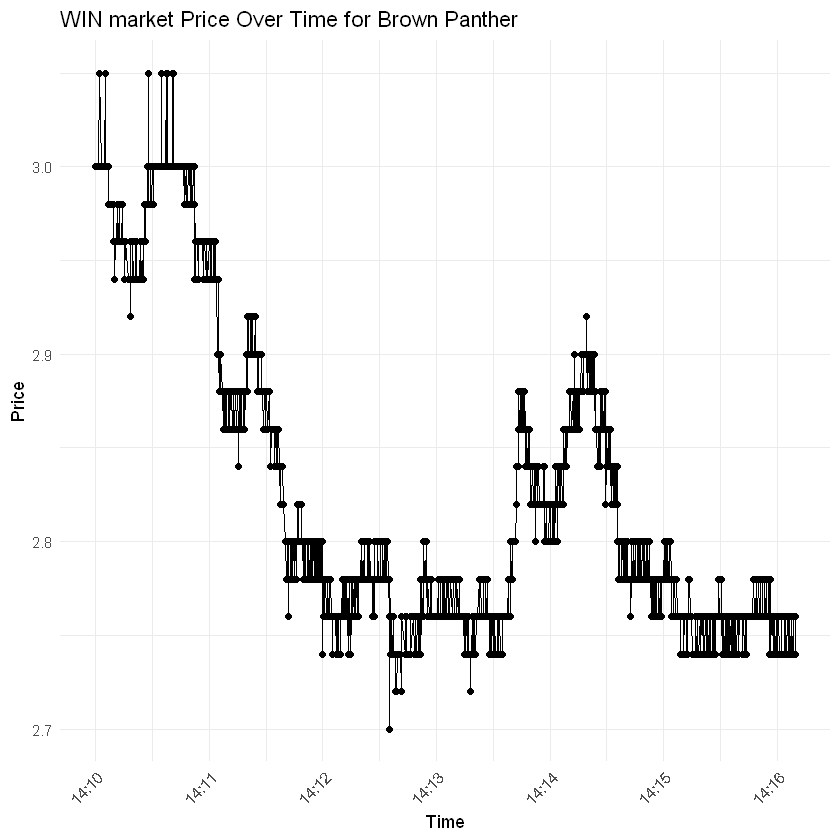

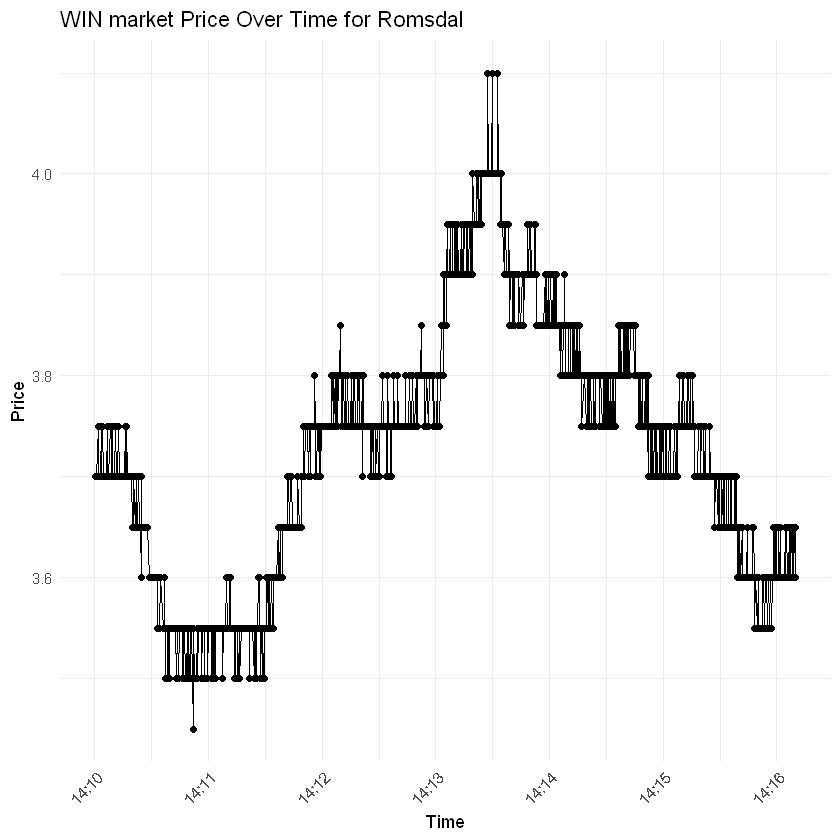

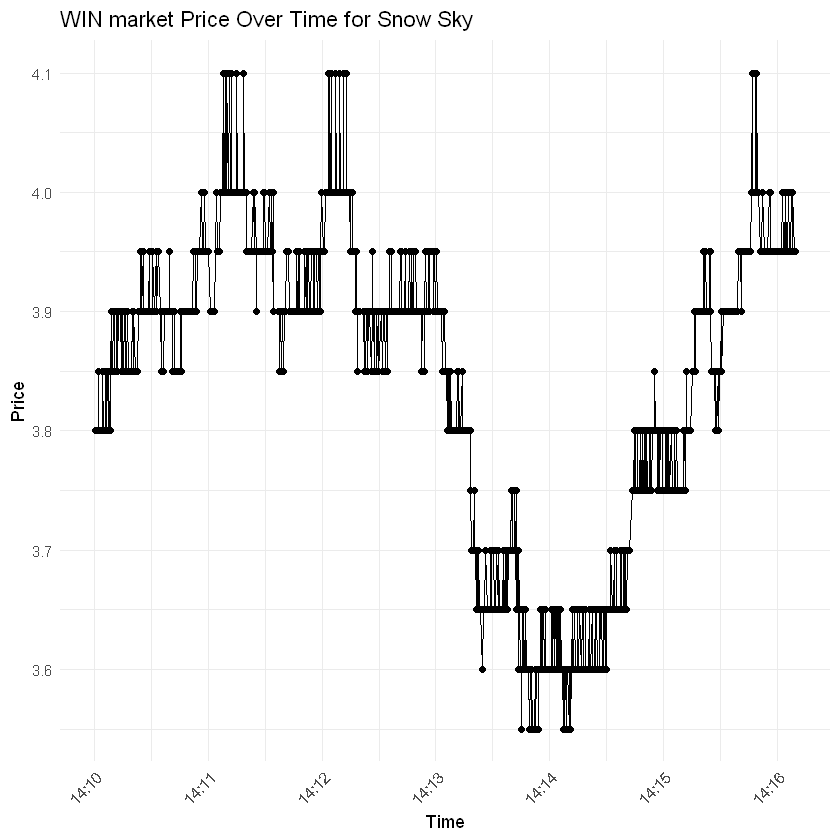

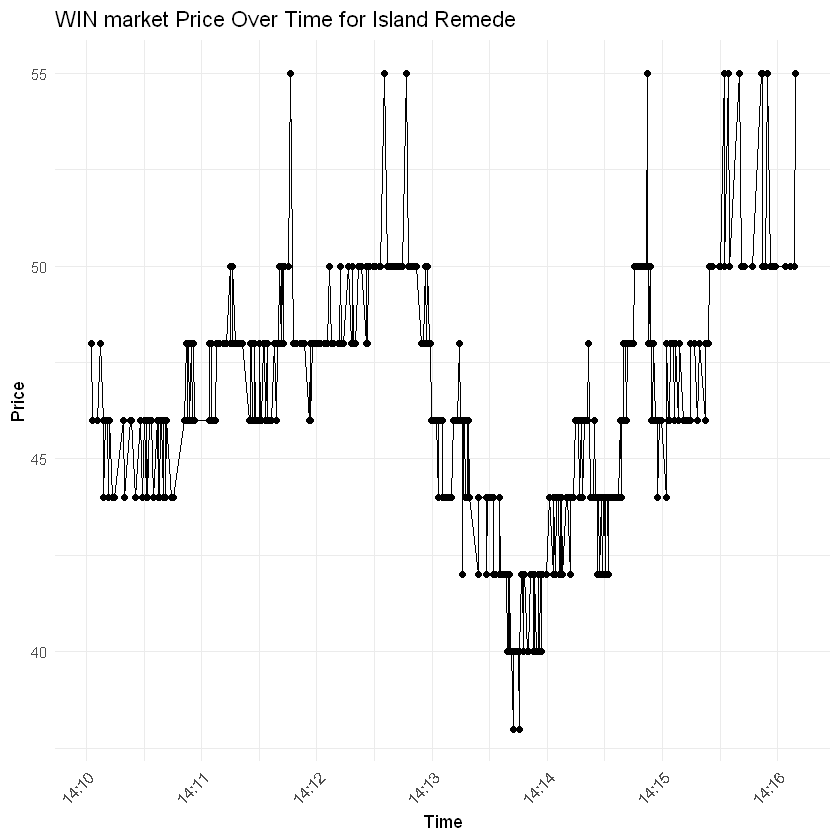

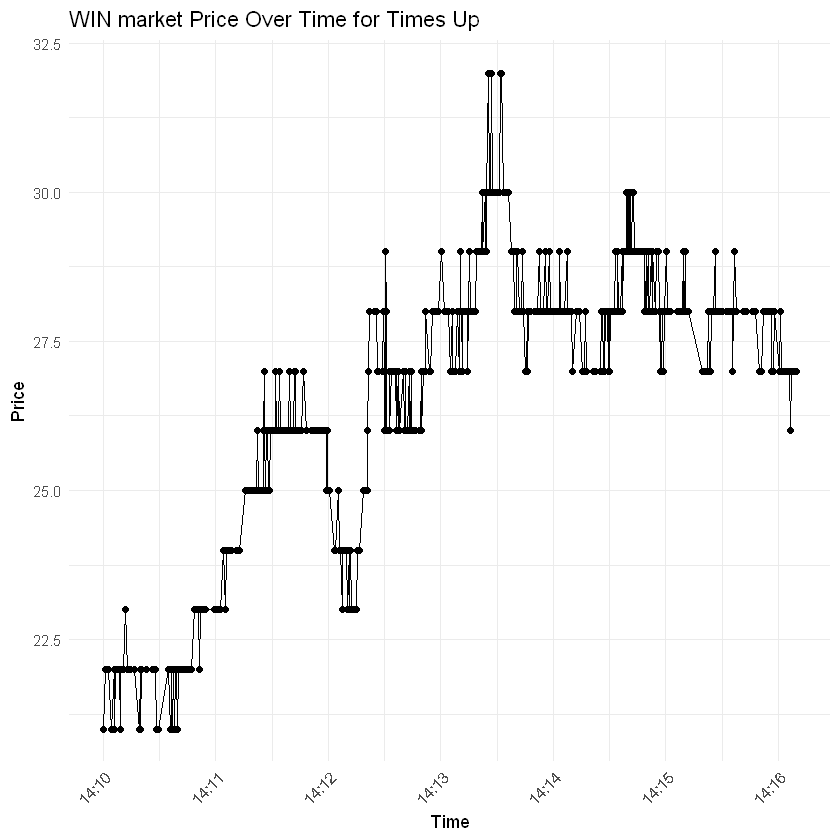

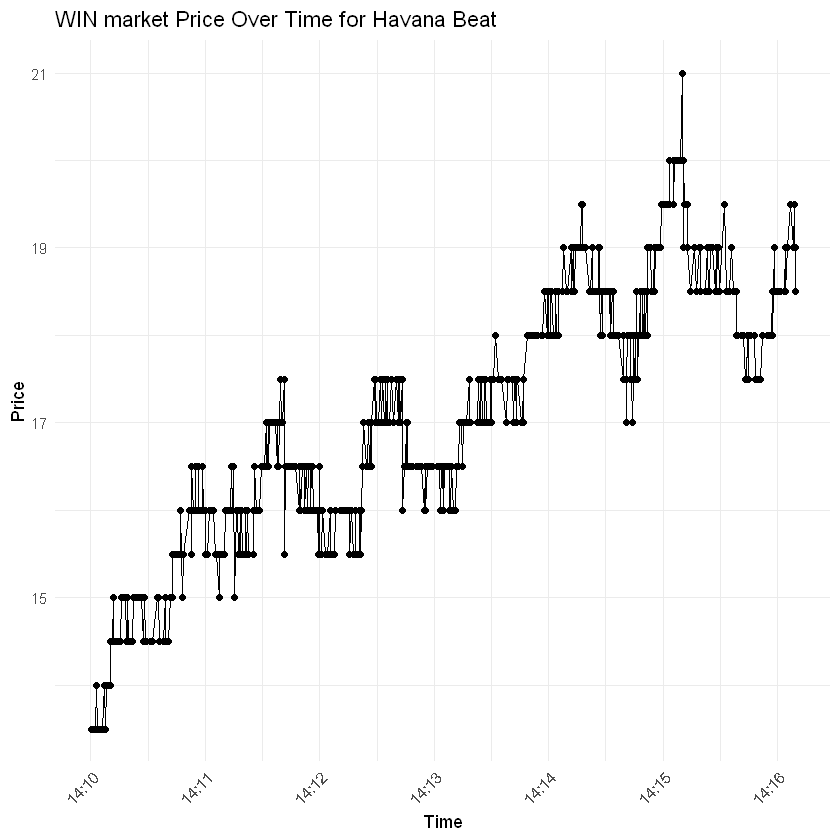

In [55]:
# Loop through each horse and create a plot and save dataframe
for (horse in unique(WIN_PRO_df$horse_name)) {
  horse_df <- WIN_PRO_df_PP %>% filter(horse_name == horse)
  
  # Calculate the size column for each horse within the loop
  horse_df <- horse_df %>%
    arrange(timestamp) %>%
    mutate(size = traded_volume - lag(traded_volume, default = first(traded_volume)),
           size = ifelse(size < 0, 0, size))
  
  # Print a sample of the horse-specific dataframe to check the size column
  head(horse_df)
  
  # Save the horse-specific dataframe to a variable named after the horse
  assign(paste0(gsub(" ", "_", horse), "_WIN_df"), horse_df)
# Create the plot with only price
  p <- ggplot(data = horse_df, aes(x = timestamp, y = price)) +
    geom_line() +
    geom_point() +
    labs(
      title = paste("WIN market Price Over Time for", horse),
      x = "Time",
      y = "Price"
    ) +
    theme_minimal() +
    theme(
      axis.text.x = element_text(angle = 45, hjust = 1),
      legend.position = "bottom"
    ) +
    scale_x_datetime(date_breaks = "1 min", date_labels = "%H:%M")
  
  # Print the plot
  print(p)
}
  

### EXPLORATORY DATA ANALYSIS (SELECTING SNOW SKY)


In [56]:
head(Snow_Sky_WIN_df)

,timestamp_unix,market_id,horse_id,last_traded_price,traded_volume,in_play,timestamp,size,price,horse_name
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dttm>,<dbl>,<dbl>,<chr>
1,1.431699e+12,1.118771,7560122,3.80,23523.10,False,2015-05-15 14:10:00,0.00,3.80,Snow Sky
2,1.431699e+12,1.118771,7560122,3.80,23533.10,False,2015-05-15 14:10:00,10.00,3.80,Snow Sky
3,1.431699e+12,1.118771,7560122,3.80,23539.46,False,2015-05-15 14:10:01,6.36,3.80,Snow Sky
4,1.431699e+12,1.118771,7560122,3.80,23739.46,False,2015-05-15 14:10:01,200.00,3.80,Snow Sky
5,1.431699e+12,1.118771,7560122,3.85,25385.08,False,2015-05-15 14:10:02,1645.62,3.85,Snow Sky
6,1.431699e+12,1.118771,7560122,3.80,23759.46,False,2015-05-15 14:10:02,0.00,3.80,Snow Sky


In [57]:
# Load necessary libraries
library(tidyverse)
library(lubridate)
library(ggplot2)
library(forecast)
library(tseries)

# Assuming 'horse_trading_data' is your dataset containing all the trading information.

# Step 1: Data Preparation
# Filter the dataset for the horse named "Snow Sky Bird"
snow_sky_df <- Snow_Sky_WIN_df %>%
  filter(horse_name == "Snow Sky")

# Convert timestamps to proper datetime format if necessary
snow_sky_df$timestamp <- as.POSIXct(snow_sky_df$timestamp, format="%Y-%m-%d %H:%M:%S")

# Ensure data is sorted by timestamp
snow_sky_df <- arrange(snow_sky_df, timestamp)






In [58]:
# Step 2: Data Exploration
# Summary statistics of key variables
summary(snow_sky_df$price)
summary(snow_sky_df$traded_volume)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  3.550   3.700   3.850   3.829   3.950   4.100 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   428.7  21245.6  30545.0  33590.7  45024.3 151752.8 

In [59]:
# Check for missing values
sum(is.na(snow_sky_df$price))
sum(is.na(snow_sky_df$traded_volume))

# Check duplicate rows
sum(duplicated(snow_sky_df))


[1] 0

[1] 0

[1] 0

In [60]:
head(snow_sky_df)

,timestamp_unix,market_id,horse_id,last_traded_price,traded_volume,in_play,timestamp,size,price,horse_name
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dttm>,<dbl>,<dbl>,<chr>
1,1.431699e+12,1.118771,7560122,3.80,23523.10,False,2015-05-15 14:10:00,0.00,3.80,Snow Sky
2,1.431699e+12,1.118771,7560122,3.80,23533.10,False,2015-05-15 14:10:00,10.00,3.80,Snow Sky
3,1.431699e+12,1.118771,7560122,3.80,23539.46,False,2015-05-15 14:10:01,6.36,3.80,Snow Sky
4,1.431699e+12,1.118771,7560122,3.80,23739.46,False,2015-05-15 14:10:01,200.00,3.80,Snow Sky
5,1.431699e+12,1.118771,7560122,3.85,25385.08,False,2015-05-15 14:10:02,1645.62,3.85,Snow Sky
6,1.431699e+12,1.118771,7560122,3.80,23759.46,False,2015-05-15 14:10:02,0.00,3.80,Snow Sky


In [61]:
# # Extract timestamp column and price column
snow_sky_df <- data.frame(timestamp = snow_sky_df$timestamp, price = snow_sky_df$price)

# Aggregate data by unique timestamps
snow_sky_df <- snow_sky_df %>%
  group_by(timestamp) %>%
  summarize(price = mean(price, na.rm = TRUE))




In [62]:
head(snow_sky_df)

timestamp,price
<dttm>,<dbl>
2015-05-15 14:10:00,3.80
2015-05-15 14:10:00,3.80
2015-05-15 14:10:01,3.80
2015-05-15 14:10:01,3.80
2015-05-15 14:10:02,3.85
2015-05-15 14:10:02,3.80


In [63]:
str(snow_sky_df)

tibble [1,152 × 2] (S3: tbl_df/tbl/data.frame)
 $ timestamp: POSIXct[1:1152], format: "2015-05-15 14:10:00" "2015-05-15 14:10:00" ...
 $ price    : num [1:1152] 3.8 3.8 3.8 3.8 3.85 3.8 3.8 3.8 3.8 3.8 ...


In [64]:
# Extract the price data
price_data <- snow_sky_df$price

# Create a time series object with a frequency of 1 observation per second
win_price_ts <- ts(price_data, frequency = 1, start = c(2015, as.numeric(format(min(snow_sky_df$timestamp), "%j"))))

# Check the structure of the time series object
str(win_price_ts)



head(win_price_ts)

 Time-Series [1:1152] from 2149 to 3300: 3.8 3.8 3.8 3.8 3.85 3.8 3.8 3.8 3.8 3.8 ...


A Time Series:
[1] 3.80 3.80 3.80 3.80 3.85 3.80

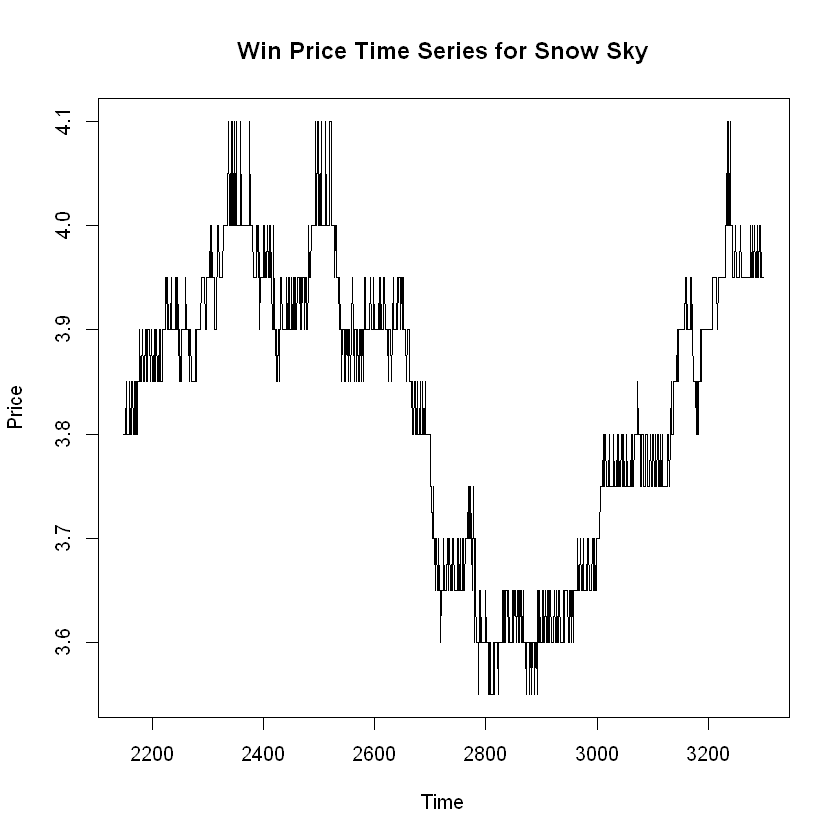

In [65]:
plot(win_price_ts, main="Win Price Time Series for Snow Sky", xlab="Time", ylab="Price", type="l")

In [66]:
# Step 4: Statistical Tests
# Testing for stationarity
adf_test_result <- adf.test(win_price_ts, alternative = "stationary")
print(adf_test_result)




	Augmented Dickey-Fuller Test

data:  win_price_ts
Dickey-Fuller = -1.0147, Lag order = 10, p-value = 0.9364
alternative hypothesis: stationary



Its not stationary. Therefore we need to break it down and to understand the underlying components.


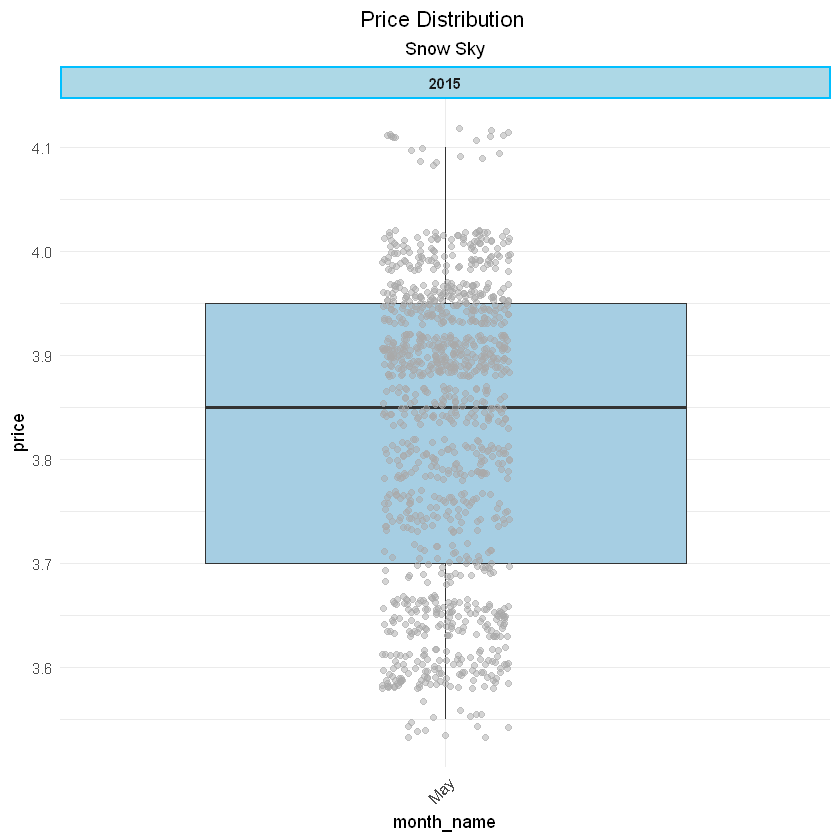

In [67]:
# Enhanced boxplot visualization of monthly price distribution per year
snow_sky_df %>%
  mutate(year = year(timestamp), month = month(timestamp), month_name = month(timestamp, label = TRUE)) %>%
  ggplot(aes(x = month_name, y = price, fill = month_name)) +  # Use month name and fill by month
  geom_boxplot(outlier.shape = NA) +  # Remove default outlier points
  geom_jitter(width = 0.1, alpha = 0.5, color = "darkgray") +  # Add jittered points for individual data observation
  scale_fill_brewer(palette = "Paired") +  # Apply a color palette for aesthetics
  labs(title = "Price Distribution ",
       subtitle = "Snow Sky",) +
  facet_wrap(~year) +  # Facet by year to see year-wise trends
  theme_minimal() +  # Use a minimal theme
  theme(
    strip.background = element_rect(fill = "lightblue", color = "deepskyblue", size = 1),  # Customize facet headers
    strip.text = element_text(face = "bold"),  # Bold facet header text
    axis.text.x = element_text(angle = 45, hjust = 1),  # Improve x-axis label readability
    legend.position = "none",  # Hide the legend as the color is self-explanatory
    plot.title = element_text(hjust = 0.5),  # Center the title
    plot.subtitle = element_text(hjust = 0.5)  # Center the subtitle
  )


In [68]:
# Step 5: Decomposition of Time Series (if seasonal patterns expected)

# Install necessary packages if not already installed
# install.packages("tsibble")
# install.packages("feasts")
# install.packages("fabletools")

# Load necessary libraries
library(tidyverse)
library(lubridate)
library(tsibble)
library(feasts)
library(fabletools)






In [ ]:
# Step 5: Decomposition of Time Series (if seasonal patterns expected)

decomposed <- stl(win_price_ts, s.window = "periodic")
plot(decomposed)



ERROR: Error in stl(win_price_ts, s.window = "periodic"): series is not periodic or has less than two periods


In [ ]:
# Correlation analysis
correlation <- cor(snow_sky_df$traded_volume, snow_sky_df$price, use = "complete.obs")
print(paste("Correlation between price and traded volume: ", correlation))



ERROR: Error in cor(snow_sky_df$traded_volume, snow_sky_df$price, use = "complete.obs"): 'x' must be numeric


In [ ]:
plot()

In [ ]:
snow_sky_diff_1 <- diff(snow_sky_df$price, lag = 1)



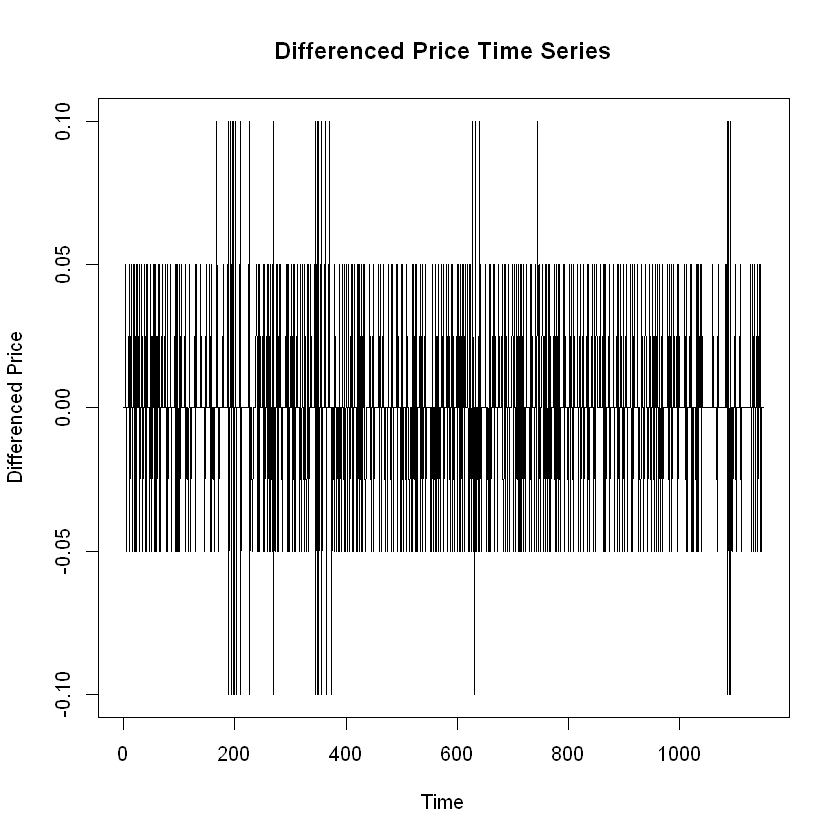

In [ ]:
plot(snow_sky_diff_1, main="Differenced Price Time Series", xlab="Time", ylab="Differenced Price", type="l")

In [ ]:
adf_result_diff <- adf.test(snow_sky_diff_1, alternative = "stationary")
print(adf_result_diff)

Warning message in adf.test(snow_sky_diff_1, alternative = "stationary"):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  snow_sky_diff_1
Dickey-Fuller = -11.195, Lag order = 10, p-value = 0.01
alternative hypothesis: stationary



## Test Stationarity of the Remainder
After decomposition, the remainder component should ideally be stationary. However, testing for stationarity is crucial to confirm.

In [ ]:
# Extract components
seasonal <- decomposed$time.series[, "seasonal"]
trend <- decomposed$time.series[, "trend"]
remainder <- decomposed$time.series[, "remainder"]

In [ ]:
library(tseries)
# ADF test on the remainder
adf_test_remainder <- adf.test(remainder, alternative = "stationary")
print(adf_test_remainder)


## Handling Non-stationarity